# 2 Player FPSB Auction with symmetric valuation distributions

## Imports

In [1]:
import os
import sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
from timeit import default_timer as timer

In [2]:
import torch
import torch.nn as nn
import torch.nn.utils as ut
from torch.optim.optimizer import Optimizer, required

In [3]:
from bnelearn.strategy import NeuralNetStrategy, TruthfulStrategy
from bnelearn.bidder import Bidder
from bnelearn.mechanism import FirstPriceSealedBidAuction, VickreyAuction
from bnelearn.optimizer import ES
from bnelearn.environment import AuctionEnvironment

In [4]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
#
#plt.ion()

In [5]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

# Use specific cuda gpu if desired 
#(i.e. for running multiple experiments in parallel)
specific_gpu = 2
if cuda and specific_gpu:
    torch.cuda.set_device(specific_gpu)

print(device)

cuda


## Settings

The following cell fully defines an experiment

In [6]:
run_dir = 'fpsb_2p_symmetric_normal'
run_name = 'best_high_batch_and_permutations4'
logdir = os.path.join(root_path, 'notebooks', run_dir , run_name)

## Experiment setup
n_players = 2
n_items = 1

# valuation distribution
valuation_mean = 10.0
valuation_std = 5.0

def strat_to_bidder(strategy, batch_size):
    return Bidder.normal(valuation_mean, valuation_std, strategy, batch_size = batch_size, n_players=1)

## Environment settings
#training batch size
batch_size = 2**14
input_length = 1

# strategy model architecture
size_hidden_layer = 10

# optimization params
epoch = 10000
learning_rate = 1e-1
lr_decay = True
lr_decay_every = 1000
lr_decay_factor = 0.7
baseline = True
momentum = 0.7

sigma = .02 #ES noise parameter
n_perturbations = 256

# plot and log training options
plot_epoch = 500
plot_points = min(100, batch_size)
plot_xmin = int(max(0, valuation_mean - 3*valuation_std))
plot_xmax = int(valuation_mean + 3*valuation_std)

plot_ymin = 0
plot_ymax = 12

## Optimal Bid Function

According to Menezes et al. 2005., the optimal bid for symmetric valuations $v$ that are distributed with cdf $F(v)$ for $n$ players in this setting is given by

$$b^*(v) = v - \frac{\int_0^v F(x)^{n-1} dx}{F(v)^{n-1}} $$


We implement it here for calculating comparison metrics.

In [7]:
import scipy.integrate as integrate

common_dist = torch.distributions.normal.Normal(loc = valuation_mean, scale = valuation_std)

# TODO: investigate where everything is allocated. possibly move GPU vectors to CPU completely instead of shuffling around for integration?
def optimal_bid(valuation: torch.Tensor or np.ndarray or float) -> torch.Tensor:
    
    # For float and numpy --> convert to tensor
    if not isinstance(valuation, torch.Tensor):
        valuation = torch.tensor(valuation, dtype = torch.float)           
    # For float / 0d tensors --> unsqueeze to allow list comprehension below
    if valuation.dim() == 0:
        valuation.unsqueeze_(0)
    
    # shorthand notation for F^(n-1)
    Fpowered = lambda v: torch.pow(common_dist.cdf(v), n_players - 1)  
    
    # do the calculations
    numerator = torch.tensor(
            [integrate.quad(Fpowered, 0, v)[0] for v in valuation],
            device = valuation.device
        ).reshape(valuation.shape)                                 
    return valuation - numerator / Fpowered(valuation)

# Setting up the Environment

In [8]:
def log_hyperparams(writer, e):
    writer.add_scalar('hyperparams/batch_size', batch_size, e)
    writer.add_scalar('hyperparams/size_hidden_layer', size_hidden_layer, 0)
    writer.add_scalar('hyperparams/learning_rate', learning_rate, e)
    writer.add_scalar('hyperparams/momentum', momentum, e)
    writer.add_scalar('hyperparams/sigma', sigma, e)
    writer.add_scalar('hyperparams/n_perturbations', n_perturbations, e)
   
    
# predefine points for plotting optimal curve to save cpu-bound integrations
v_opt = np.linspace(plot_xmin, plot_xmax, 100) # 100 points more than enough
b_opt = optimal_bid(v_opt).numpy()

def plot_bid_function(fig, v,b, writer=None, e=None, plot_points=plot_points):
    
    # subsample points and plot
    v = v.detach().cpu().numpy()[:plot_points]
    b= b.detach().cpu().numpy()[:plot_points]
    
    fig = plt.gcf()
    plt.cla()
    plt.xlim(plot_xmin, plot_xmax)
    plt.ylim(plot_ymin, plot_ymax)
    plt.plot(v,b, 'o', v_opt, b_opt, 'r--')
    #if is_ipython:
    #    display.clear_output(wait=True)
    display.display(plt.gcf())
    if writer:
        writer.add_figure('eval/bid_function', fig, e)  

Initialize the model.
We'll ensure the initialization provides positive outputs on the domain we are interested in, as otherwise we can't learn.

In [31]:
output_is_positive = False
while not output_is_positive:
    model = NeuralNetStrategy(input_length,
                              size_hidden_layer = size_hidden_layer,
                              requires_grad=False
                             ).to(device)
    
    if model(torch.tensor([float(valuation_mean)], device=device)) > 0:
        output_is_positive = True    

In [33]:
mechanism = FirstPriceSealedBidAuction(cuda = True)
env = AuctionEnvironment(mechanism,
                  agents = [], #dynamically built
                  max_env_size = 1, #
                  batch_size = batch_size,
                  n_players =n_players,
                  strategy_to_bidder_closure = strat_to_bidder
                 )
optimizer = ES(model=model, environment = env,
               lr = learning_rate, momentum=momentum,
               sigma=sigma, n_perturbations=n_perturbations,
               baseline=baseline)

## Training

/opt/anaconda/anaconda3/envs/bnelearn/lib/python3.7/site-packages/ipykernel_launcher.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Epoch 0: 	total share: 0.212547, diff: -4.532556, 	utility: 8.825401


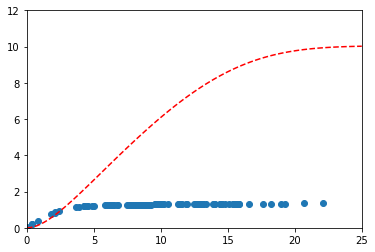

Logging checkpoint took 62.908489s.
Epoch 500: 	total share: 1.430601, diff: 2.448415, 	utility: 1.882000


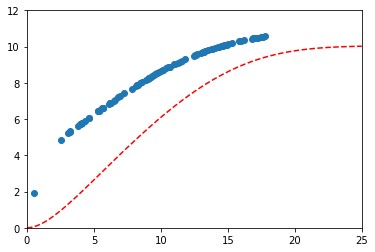

Logging checkpoint took 61.055897s.
Epoch 1000: 	total share: 1.306876, diff: 1.762933, 	utility: 2.492315


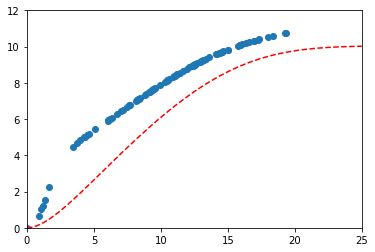

Logging checkpoint took 58.361089s.
Epoch 1500: 	total share: 1.190551, diff: 1.090834, 	utility: 3.244036


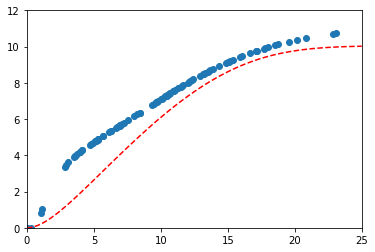

Logging checkpoint took 60.370459s.
Epoch 2000: 	total share: 1.203106, diff: 1.162228, 	utility: 3.148228


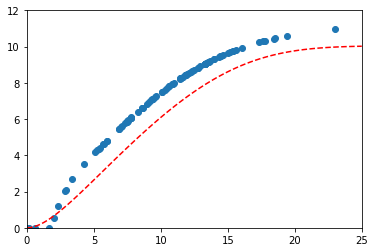

Logging checkpoint took 59.718744s.
Epoch 2500: 	total share: 1.347156, diff: 1.991000, 	utility: 2.279262


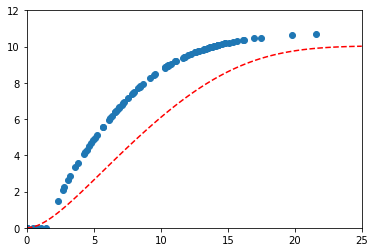

Logging checkpoint took 58.601014s.
Epoch 3000: 	total share: 1.405258, diff: 2.311115, 	utility: 1.971457


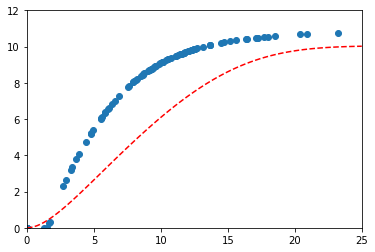

Logging checkpoint took 60.618084s.
Epoch 3500: 	total share: 1.266919, diff: 1.530466, 	utility: 2.783765


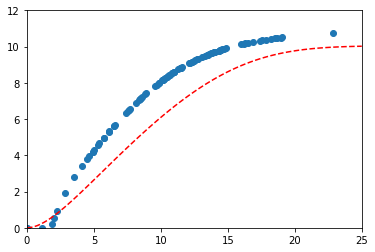

Logging checkpoint took 59.097868s.
Epoch 4000: 	total share: 1.190163, diff: 1.090345, 	utility: 3.175967


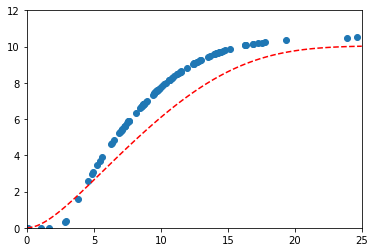

Logging checkpoint took 60.539515s.
Epoch 4500: 	total share: 0.886310, diff: -0.654317, 	utility: 4.810645


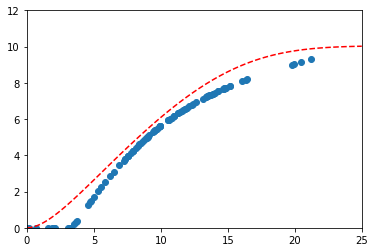

Logging checkpoint took 58.756518s.
Epoch 5000: 	total share: 1.112687, diff: 0.641921, 	utility: 3.607193


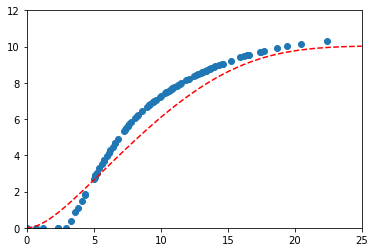

Logging checkpoint took 57.207515s.
Epoch 5500: 	total share: 0.975321, diff: -0.141835, 	utility: 4.359638


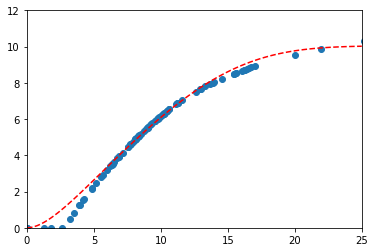

Logging checkpoint took 58.698736s.
Epoch 6000: 	total share: 0.906207, diff: -0.538100, 	utility: 4.806204


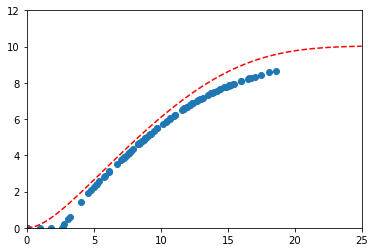

Logging checkpoint took 59.816874s.
Epoch 6500: 	total share: 1.142843, diff: 0.818664, 	utility: 3.438354


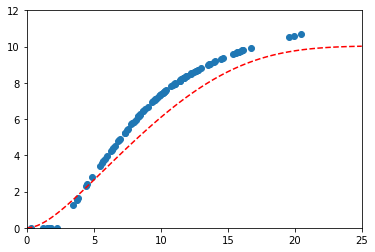

Logging checkpoint took 58.519703s.
Epoch 7000: 	total share: 1.075815, diff: 0.436786, 	utility: 3.838907


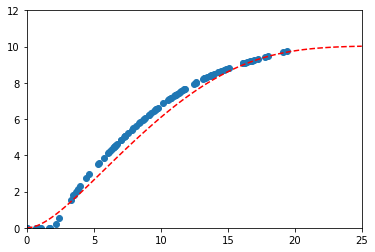

Logging checkpoint took 58.643793s.


In [ ]:
with SummaryWriter(logdir, flush_secs=120) as writer:
    torch.cuda.empty_cache()
    log_hyperparams(writer, 0)
    fig = plt.figure()
    for e in range(epoch+1):
        # lr decay?
        if lr_decay and e % lr_decay_every == 0 and e > 0:
            learning_rate = learning_rate * lr_decay_factor
            log_hyperparams(writer, e)
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

        # always: do optimizer step
        utility = -optimizer.step()
        writer.add_scalar('eval/utility', utility, e)

        if e % plot_epoch == 0:
            start_time = timer()
            # log statistics and plot current function output
            bidder = strat_to_bidder(model, batch_size)
            bidder.draw_valuations_()
            v = bidder.valuations
            b = bidder.get_action()
            share = b.mean()/optimal_bid(v).mean()
            diff = (b-optimal_bid(v)).mean()
            writer.add_scalar('eval/share', share, e)
            writer.add_scalar('eval/diff', diff, e) 
            writer.add_graph(model, bidder.valuations)            
                    
            print("Epoch {}: \ttotal share: {:.3f}, diff: {:.3f}, \tutility: {:.3f}".format(e, share, diff, utility))
            plot_bid_function(fig, v,b,writer,e)
            
            elapsed = timer() - start_time
            print("Logging checkpoint took {:.2f}s.".format(elapsed))